### 1. Load model at checkpoint

In [ ]:
# importing required libraries
import torch.nn as nn
import torch
import warnings
import math
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from model import TFModel
import Rotary_test
import utils
import data

warnings.simplefilter("ignore")
utils.fix_random_seed(42)

class Config:
    """
    This is the configuration class to store the configuration of a TFModel. It is used to
    instantiate a model according to the specified arguments, defining the model architecture.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# loading config file
dirname = "2_layer_64_vocab"
with open(f"data/{dirname}/config.json") as f:
    config_args = json.load(f)
    config_args["rotary_theta"] = 10000
config = Config(**config_args)

d_model = config.d_model
num_heads = config.num_heads
max_seq_len = config.max_seq_len
rotary_theta = config.rotary_theta
R = Rotary_test.calc_rotary_R_mat_simple(d_model, rel_dist=1)
print(R.shape)

# loading model checkpoint
if config.device == "cuda":
    checkpoint = torch.load(f"data/{dirname}/ckpt_1020.pt", map_location=torch.device('cpu'))
    config.device = "cpu"

config.trainable_norm = True
model = TFModel(config)
model.load_state_dict(checkpoint, strict=False)
model.eval()

torch.Size([64, 64])


TFModel(
  (embed): Embedding(
    (embed): Embedding(64, 64)
  )
  (h): ModuleList(
    (0-1): 2 x TFBlock(
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=64, bias=True)
)

### 2. Compute singular space of embedding layer

In [14]:
W = model.embed.embed.weight.detach() # (vocab_size, d_model)
# W = (model.h[0].mha.W_o.weight.T @ model.h[0].mha.W_v.weight / math.sqrt(d_model)).detach()
W_nml = F.normalize(W, dim=1).detach()
W_ln = model.h[0].ln_1(W).detach()
U, s, Vt = torch.linalg.svd(W)
U2, s2, Vt2 = torch.linalg.svd(W_nml)
U3, s3, Vt3 = torch.linalg.svd(W_ln)

W_qk = model.h[1].mha.W_q.weight.T @ model.h[1].mha.W_k.weight / math.sqrt(d_model) # only works for num_heads = 1 and ignoring rotary
U_qk, s_qk, Vt_qk = torch.linalg.svd(W_qk.detach())

def get_diagS_from_svd(U,s,Vt):
    diagS = torch.zeros((U.shape[0], Vt.shape[0]))
    diagS[range(min(U.shape[0], Vt.shape[0])), range(min(U.shape[0], Vt.shape[0]))] = s
    return diagS

diagS = get_diagS_from_svd(U, s, Vt)
diagS_qk = get_diagS_from_svd(U_qk, s_qk, Vt_qk)

### 3. Visualize inner product b/a perterbation

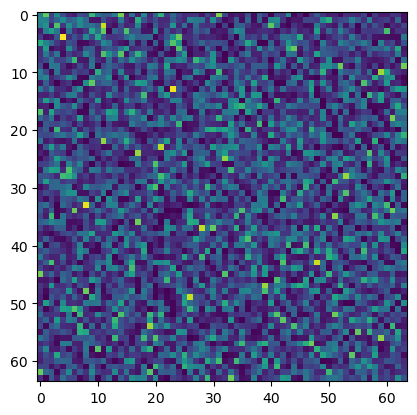

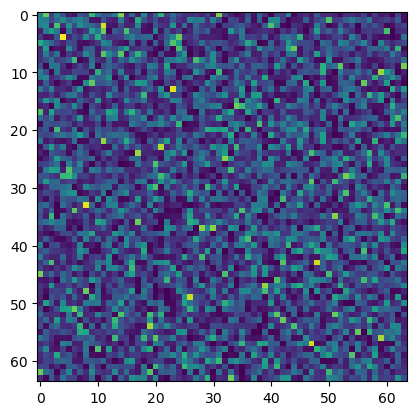

In [15]:
plt.imshow(torch.abs(Vt_qk @ Vt.T))
plt.show()

W_perturb = W + 1e-2 * torch.randn_like(W)
U_perturb, s_perturb, Vt_perturb = torch.linalg.svd(W_perturb)
plt.imshow(torch.abs(Vt_qk @ Vt_perturb.T))


### 4. Perturb at a subspace of embedding matrix

In [20]:
from train_module import *

criterion = (
    nn.CrossEntropyLoss(label_smoothing=0.1)
    if config.label_smoothing
    else nn.CrossEntropyLoss()
)

p = make_distr(config)
vocab = torch.arange(config.vocab_size).type(torch.LongTensor)

src_test, lens_test, starts_test, patterns = gen_simulated_data(
    distr=p,
    vocab=vocab,
    max_seq_len=config.max_seq_len,
    regime=config.regime,
    sample_size=config.sample_size_test,
    pool_size=config.pool_size,
    patterns=None,
    rep_l=config.rep_l,
    rep_h=config.rep_h,
    device=config.device,
)

train_dataset = []
for epoch in range(20):
    src, lens_train, starts_train, _ = gen_simulated_data(
        distr=p,
        vocab=vocab,
        max_seq_len=config.max_seq_len,
        regime=config.regime,
        sample_size=config.batch_size,
        pool_size=config.pool_size,
        patterns=patterns,
        rep_l=config.rep_l,
        rep_h=config.rep_h,
        device=config.device,
    )
    M = get_mask(
        src,
        lens_train,
        starts_train,
        ignore_segment=config.ignore_segment,
        ignore_burning=config.ignore_burning,
    )
    train_dataset.append((src, lens_train, starts_train, _, M))

# print("completed")
# print(list(model.named_parameters()))
mean_diff_curve = []
epochs = [0, 300, 600, 900, 1020, 3000, 6000, 9000, 12000, 18000, 24000, 30000]
for epoch in epochs:
    print(epoch)
    if config.device == "cuda":
        checkpoint = torch.load(f"data/{dirname}/ckpt_{epoch}.pt", map_location=torch.device('cpu'))
        config.device = "cpu"

    config.trainable_norm = True
    model = TFModel(config)
    model.load_state_dict(checkpoint, strict=False)
    model.eval()

    diff = get_robustness_subspace(model, criterion, dataset=train_dataset, num_perturb=100, r_perturb=1e-5, data_sample_size=50, config=config, perturb_name='embed.embed.weight')

    mean_diff = [np.mean(diff[i]) * 1e10 for i in range(len(diff.keys()))]
    mean_diff_curve.append(mean_diff)


0
300
600
900
1020
3000
6000
9000
12000
18000
24000
30000


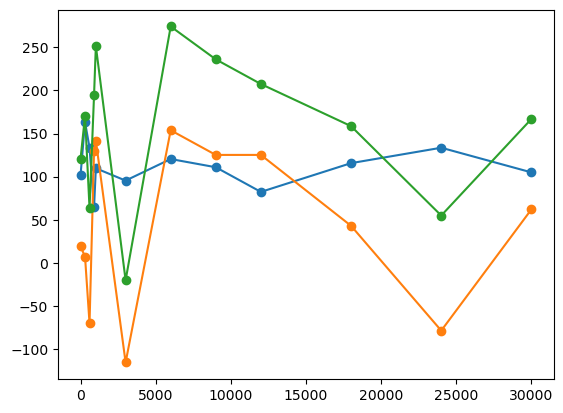

In [22]:
mean_diff_curve = np.array(mean_diff_curve)
for i in range(mean_diff_curve.shape[1]):
    plt.plot(epochs, mean_diff_curve[:,i], '-o')
plt.plot(epochs, np.sum(mean_diff_curve, axis=1), '-o')
plt.show()

Sharpness at epoch 1020: 425, 225, total 280
Sharpness at epoch 30000: -50, 200, total 55

In [18]:
'''
d = 64
U1, _ = torch.linalg.qr(torch.randn(d, d))
V1t, _ = torch.linalg.qr(torch.randn(d, d))
S1 = diagS
S2 = diagS_qk
V2t = V1t @ Vt_qk @ Vt.T

M1 = U1 @ S1 @ V1t
M2 = U2 @ S2 @ V2t
loss = torch.trace(M1 @ M2 @ M1.T)
diff = []

for t in range(10000):
    M1_p = M1 + 1e-3 * torch.randn_like(M1)
    loss_p = torch.trace(torch.softmax(M1_p @ M2 @ M1_p.T, dim=1))
    diff.append(loss_p - loss)
print(np.mean(diff))

V2t, _ = torch.linalg.qr(torch.randn(d,d))
M2 = U2 @ S2 @ V2t
loss = torch.trace(M1 @ M2 @ M1.T)
diff = []
for t in range(10000):
    M1_p = M1 + 1e-3 * torch.randn_like(M1)
    loss_p = torch.trace(torch.softmax(M1_p @ M2 @ M1_p.T, dim=1))
    diff.append(loss_p - loss)
print(np.mean(diff))
'''

'\nd = 64\nU1, _ = torch.linalg.qr(torch.randn(d, d))\nV1t, _ = torch.linalg.qr(torch.randn(d, d))\nS1 = diagS\nS2 = diagS_qk\nV2t = V1t @ Vt_qk @ Vt.T\n\nM1 = U1 @ S1 @ V1t\nM2 = U2 @ S2 @ V2t\nloss = torch.trace(M1 @ M2 @ M1.T)\ndiff = []\n\nfor t in range(10000):\n    M1_p = M1 + 1e-3 * torch.randn_like(M1)\n    loss_p = torch.trace(torch.softmax(M1_p @ M2 @ M1_p.T, dim=1))\n    diff.append(loss_p - loss)\nprint(np.mean(diff))\n\nV2t, _ = torch.linalg.qr(torch.randn(d,d))\nM2 = U2 @ S2 @ V2t\nloss = torch.trace(M1 @ M2 @ M1.T)\ndiff = []\nfor t in range(10000):\n    M1_p = M1 + 1e-3 * torch.randn_like(M1)\n    loss_p = torch.trace(torch.softmax(M1_p @ M2 @ M1_p.T, dim=1))\n    diff.append(loss_p - loss)\nprint(np.mean(diff))\n'